# A Basic AMPL Model

AMPL is an algebraic modeling language for mathematical optimization that integrates with the Python programming environment. It enables users to define optimization models consisting of decision variables, objective functions, and constraints, and to compute solutions using a variety of open-source and commercial solvers.

This notebook introduces basic concepts of AMPL needed to formulate and solve the [production planning problem](https://github.com/fdabrandao/MO-book-with-AMPL/blob/dev/notebooks/01/production-planning.ipynb) introduced in a companion notebook:

* Variables
* Objectives
* Constraints
* Solving
* Reporting the solution

The AMPL model shown in this notebook is a direct translation of the mathematical model into basic AMPL components. In this approach, parameter values from the mathematical model are included directly in the AMPL model for simplicity. This method works well for problems with a small number of decision variables and constraints, but it limits the reuse of the model. Another notebook will demonstrate AMPL features for writing models for more generic, "data-driven" applications.

## Preliminary Step: Install AMPL and Python tools

We start by installing amplpy, the application programming interface (or API) that integrates the AMPL modeling language with the Python programming language. Also we install two Python utilities, matplotlib and pandas, that will be used in the parts of this notebook that display results.

These installations need to be done only once for each Python environment on a personal computer. A new installation must be done for each new Colab session, however.

In [ ]:
# install dependencies
%pip install -q amplpy matplotlib pandas

## Step 1. Import AMPL

The first step for a new AMPL model is to import the needed components into the AMPL environment. The Python code shown below is used at the beginning of every notebook. There are just two elements that may vary according to your needs:

* The `modules` line lists the solvers that you intend to use. In the present notebook we list `"cbc"` and `"highs"` to request the free CBC and HiGHS solvers.

* The `license_uuid` is a code that determines your permissions to use AMPL and commercial solvers. Here the UUID is set to `"default"` which gets you full-featured versions of AMPL and most popular solvers, limited only by the size of the problems that can be solved; this is sufficient for all of our small examples.

If you have obtained a different license for AMPL and one or more solvers, you can get its UUID from your account on the AMPL Portal. If you are using these notebooks in a course, your instructor may give you a UUID to use.

This step also creates a new object, named `ampl`, that will be referenced when you want to refer to various components and methods of the AMPL system within Python statements.

In [2]:
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["cbc", "highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://colab.ampl.com).


## Step 2. Decision variables

To define the decision variables of your model, you use AMPL `var` statements. Our basic production planning model has 5 decision variables, so they can be defined by 5 `var` statements.

Each statement starts with the keyword `var` and a unique name for the variable. Then lower and upper bounds for the variable are specified by `>=` and `<=` phrases. Bounds are optional; in this model, `>= 0` is specified for all 5 variables, but some of them have no specified upper bound.

The `%%ampl_eval` line at the beginning of this cell tells Python to send all of the statements in the cell to AMPL. To add an AMPL comment line, put a `#` character at the beginning of the line.

In [12]:
%%ampl_eval
# define decision variables

reset;

var xM >= 0;
var xA >= 0, <= 80;
var xB >= 0, <= 100;

var yU >= 0, <= 40;
var yV >= 0;

## Step 3. Objective

Since this is a maximization problem, an AMPL `maximize` statement specifies the objective function. (If it were a minimization, a `minimize` statement would be used instead.)

The `maximize` keyword is followed by a name for the objective &mdash; we can call it `Profit` &mdash; and a colon (`:`) character. Then the expression for the objective function is written in AMPL just the same as we previously wrote it in the mathematical formulation.

Notice that all AMPL statements are ended with a semicolon (`;`) character. A long statement can be spread over more than one line, as in the case of our `maximize` statement for this model.

In [13]:
%%ampl_eval
# define objective function

maximize Profit:
   270*yU + 210*yV - 10*xM - 50*xA - 40*xB;

## Step 4. Constraints

AMPL specifies constraints in much the same way as the objective, with just a few differences:

* An AMPL constraint definition begins with the keywords `subject to`.

* The expression for a constraint contains a less-than (`<=`), greater-than (`>=`), or equals (`=`) operator.

Just as for the objective, each constraint has a name, and the expressions for the three constraints are the same as in the mathematical formulation.

(You can abbreviate `subject to` as `subj to` or `s.t.` Or you can leave it out entirely; a statement that does not begin with a keyword is assumed by AMPL to be a constraint definition.)



In [14]:
%%ampl_eval
# define constraints

subj to raw_materials: 10*yU + 9*yV <= xM;
subj to labor_A: 2*yU + 1*yV <= xA;
subj to labor_B: 1*yU + 1*yV <= xB;

## Step 5. Solving

With the model now fully specified, the next step is to compute optimal values for the decision variables. From this point onward, our cells will contain Python statements and function calls, including calls to amplpy functions that manage the integration of AMPL and Python.

There are many ways to assign values to the variables, so that all of the bounds and all of the constraints are satisfied. Each of these ways gives a *feasible* solution for our model. A solution is *optimal* if it gives the highest possible value of the objective function among all the feasible solutions.

To compute an optimal solution, we call a *solver:* a separate program that applies numerical algorithms to determine optimal values for the variables. There are just a few steps:

* The AMPL commands `show` and `expand` display the model components and expressions, so that you can check that they have been specified correctly. We use the `amplpy.AMPL.eval` function to run these commands in AMPL.

* The `amplpy.AMPL.option` attribute sets the `"solver"` option to one of the solvers that we loaded in Step 2.

* The `amplpy.AMPL.solve` function invokes the chosen solver. AMPL takes care of converting the model to the form that the solver requires for its computation, and converting the results back to a form that can be used in Python.

To show how different solvers can be tested, we conclude by setting a different solver and solving again. As expected, the two solvers report the same optimal objective value, 2400.

In [19]:
# exhibit the model that has been built
ampl.eval("show;")
ampl.eval("expand;")

# solve using two different solvers
ampl.option["solver"] = "cbc"
ampl.solve()

ampl.option["solver"] = "highs"
ampl.solve()


variables:   xA   xB   xM   yU   yV

constraints:   labor_A   labor_B   raw_materials

objective:   Profit
maximize Profit:
	-10*xM - 50*xA - 40*xB + 270*yU + 210*yV;

subject to raw_materials:
	-xM + 10*yU + 9*yV <= 0;

subject to labor_A:
	-xA + 2*yU + yV <= 0;

subject to labor_B:
	-xB + yU + yV <= 0;

cbc 2.10.7: cbc 2.10.7: optimal solution; objective 2400
0 simplex iterations
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 2400
0 simplex iterations
0 barrier iterations


## Step 6. Reporting the solution

The final step in most applications is to report the solution in a suitable format. For this example, we demonstrate simple tabular and graphic reports using the Pandas library. For an overview of other ways to report and visualize the solutions, see also the appendix of the [gasoline-distribution](https://github.com/fdabrandao/MO-book-with-AMPL/tree/dev/notebooks/04/gasoline-distributon.ipynb) notebook.

### Accessing solution values with `display`

The amplpy `ampl.display` function shows the values of one or more AMPL expressions, computed from the current values of the variables. You can also apply this function to special expresions such as `_var` for the values of all the variables, and `_varname` for the names of all the variables.

In [24]:
# display a component of the model
ampl.display("Profit")
ampl.display("270*yU + 210*yV", "10*xM + 50*xA + 40*xB")

ampl.display("_varname", "_var")

Profit = 2400

270*yU + 210*yV = 16800
10*xM + 50*xA + 40*xB = 14400

: _varname  _var    :=
1   xM       720
2   xA        80
3   xB        80
4   yU         0
5   yV        80
;



### Accessing solution values with `get_value`

After an optimal solution has been successfully computed, the value of an AMPL expression can be retrieved in Python by use of the `ampl.get_value` function. When combined with Python `f` strings, `ampl.get_value` provides a convenient means of creating formatted reports.

In [46]:
print(f" Profit = {ampl.get_value('Profit'): 9.2f}")
print(f"Revenue = {ampl.get_value('270*yU + 210*yV'): 9.2f}")
print(f"   Cost = {ampl.get_value('10*xM + 50*xA + 40*xB'): 9.2f}")

 Profit =   2400.00
Revenue =  16800.00
   Cost =  14400.00


### Creating reports with Pandas and Matplotlib

Pandas, a freely available library for working with data in Python, is widely used in the data science community. Here we use a Pandas `Series()` object to hold and display solution data. We can then visualize the data using the matplotlib library, for instance with a bar chart.

In [40]:
import pandas as pd

# create pandas series for production and raw materials
production = pd.Series(
    {
        "U": ampl.get_value("yU"),
        "V": ampl.get_value("yV"),
    }
)

raw_materials = pd.Series(
    {
        "A": ampl.get_value("xA"),
        "B": ampl.get_value("xB"),
        "M": ampl.get_value("xM"),
    }
)

# display pandas series
display(production)
display(raw_materials)

U     0.0
V    80.0
dtype: float64

A     80.0
B     80.0
M    720.0
dtype: float64

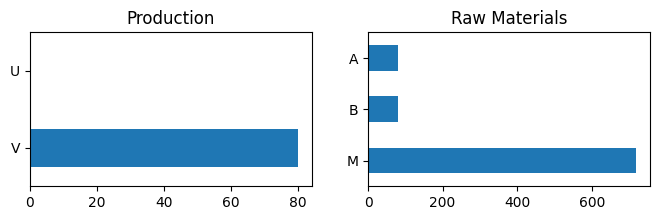

In [41]:
import matplotlib.pyplot as plt

# create grid of subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 2))

# show pandas series as horizontal bar plots
production.plot(ax=ax[0], kind="barh", title="Production")
raw_materials.plot(ax=ax[1], kind="barh", title="Raw Materials")

# show vertical axis in descending order
ax[0].invert_yaxis()
ax[1].invert_yaxis()

### Appendix???
Mention .mod file (model isolation) and pure Python execution?

In [ ]:
%%writefile production_planning_basic.mod

# decision variables
var x_M >= 0;
var x_A >= 0, <= 80;
var x_B >= 0, <= 100;

var y_U >= 0, <= 40;
var y_V >= 0;

# auxiliary variables
var revenue = 270 * y_U + 210 * y_V;
var cost = 10 * x_M + 50 * x_A + 40 * x_B;

# objective
maximize profit: revenue - cost;

# constraints
s.t. raw_materials: 10 * y_U + 9 * y_V <= x_M;
s.t. labor_A: 2 * y_U + 1 * y_V <= x_A;
s.t. labor_B: 1 * y_U + 1 * y_V <= x_B;

Overwriting production_planning_basic.mod


In [ ]:
# Create AMPL instance and load the model
ampl = AMPL()
ampl.read("production_planning_basic.mod")

# Select a solver and solve the problem
ampl.option["solver"] = SOLVER
ampl.solve()

cbc 2.10.7: cbc 2.10.7: optimal solution; objective 2400
0 simplex iterations
